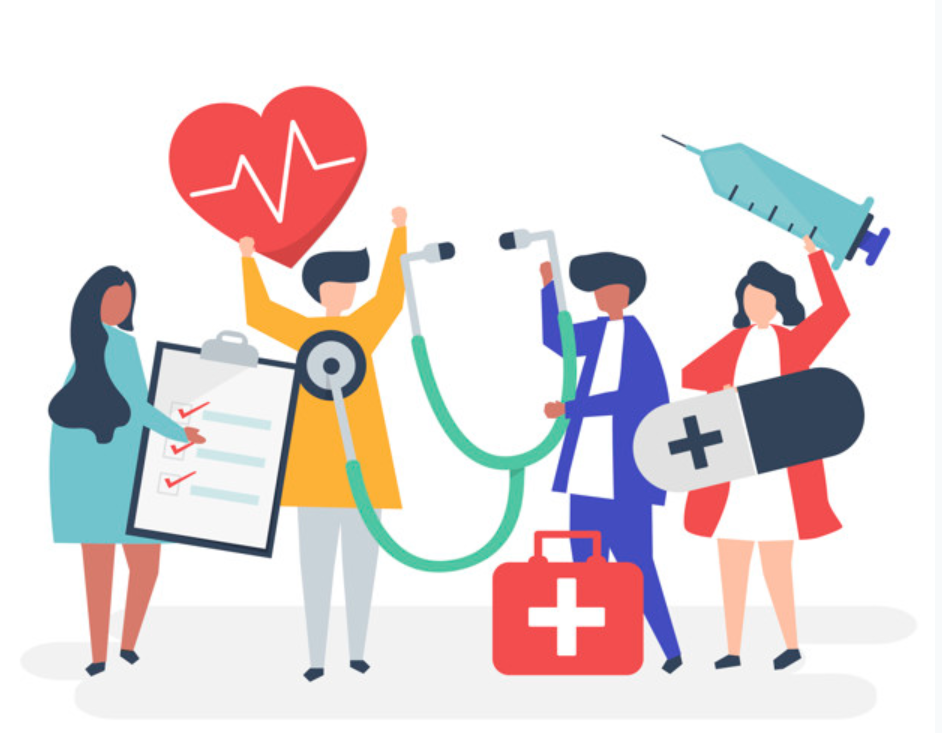

## Contexto de Negócio

Sabemos que o serviço público de saúde no Brasil e em outros países é bem precário, o que leva parte da população a buscar formas de atendimento privadas usando Planos de Saúde. 

No entanto, estes planos privados sofrem pesada regulação pela ANS - Agência Nacional de Saúde o que eleva os custos e valores das mensalidades, além dos custos associados à internação, UTI e outros procedimentos cirúrgicos. 

Mas será que existem outros fatores que influenciam o valor do plano de saúde? 

Neste estudo iremos analisar um dataset de uma seguradora americana e verificar que fatores podem influenciar o preço final de um plano de saúde. 

## Objetivo do Projeto:

Obter um modelo para prever os custos e valores para um Plano de Saúde

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Para este estudo usaremos a biblioteca PyCaret que permite análises supervisionadas e não supervisionadas com pouco código e boa acurácia. 

In [ ]:
# Carregando o Pycaret

!pip install pycaret

In [ ]:
from pycaret.datasets import get_data

Vamos importar a nossa base de dados **'insurance'** que contém informações sobre beneficiários de plano de saúde. 

In [ ]:
dados = get_data('insurance')

Analisando nossa base, temos dados simulados de beneficiários (usuários de plano de saúde) e os gastos com plano de saúde num dado intervalo de tempo. 

Os seguintes atributos estão presentes no banco de dados:

Idade em anos: age
Sexo: sex
Índice de Massa Corporal: bmi
Número de crianças vinculadas ao plano de saúde: children
Se é fumante ou não: smoker
Região dos Estados Unidos: region
Sinistro (gastos) em unidade monetária: charges

Nosso objetivo é criar modelos preditivos que retornem o atributo **'charges'** (valor do plano).

Para isso, vamos iniciar importando os modelos de regressão do PyCaret:


In [ ]:
from pycaret.regression import *

In [ ]:
# configurações de pré processamento e validação dos modelos 

regressao = setup(data = dados,
                 target = 'charges',
                 normalize = True,
                 combine_rare_levels = True,
                 remove_outliers = True,
                 session_id = 1)

### Criando um modelo inicial básico com Random Forest

O PyCaret possui uma enorme gama de algoritmos que podemos usar para nosso estudo. Neste exercício usaremos o Random Forest e faremos uma comparação para verificar sua acurácia. 

In [ ]:
models()

Aqui estamos criando o modelo com o nome 'floresta'.

In [ ]:
floresta = create_model('rf')

Agora iremos ajustar o modelo usando o método RandomSearch e como parâmetro o RMSLE (Erro Médio Quadrático Logarítmico)

In [ ]:
# Ajustando o modelo RF através do método RandomSearch

floresta_adj = tune_model(floresta, optimize = 'RMSLE', n_iter = 20)

In [ ]:
# Verificando a importância das variáveis no modelo ajustado

plot_model(floresta_adj, plot = 'feature')

Analisando as variáveis acima, vemos claramente que "smoker_yes" (fumantes) e "age" (idade), são fatores importantes na predição e composição dos valores do plano de saúde. 

Vamos agora avaliar outros modelos de machine learning disponíveis e selecionar os 3 melhores, nas suas configurações padrão:

In [ ]:
modelos = compare_models(sort = 'RMSLE', n_select = 4)

In [ ]:
modelos_tunados = [tune_model(i, optimize = 'RMSE') for i in modelos]

In [ ]:
# vamos combinar os 5 modelos tunados em um único preditor

modelo_combinado = blend_models(modelos_tunados)

In [ ]:
# verificando a performance nos dados de validação

pred = predict_model(modelo_combinado)

In [ ]:
# Aplicando o modelo final em todos os dados disponíveis

modelo_final = finalize_model(modelo_combinado)

In [ ]:
# Salvando o modelo final

save_model(modelo_final, 'final_model')

# Salvando o modelo para deploy na nuvem
save_model(modelo_final, model_name = 'deployment_28042020')

In [ ]:
# Fazendo um deploy básico

def CustoSeguro (age, sex, bmi, children, smoker, region):
    dados0 = {'age': [age], 'sex': [sex], 'bmi': [bmi], 'children': [children], 'smoker': [smoker], 'region': [region]}
    dados = pd.DataFrame(dados0)
    
    modelo = load_model('./final_model')
    
    pred = float(predict_model(modelo, data = dados)['Label'].round(2))
    valor = round(1.8*pred, 2)
    
    print(' ')
    print('Idade: {}'.format(age))
    print('Sexo: {}'.format(sex))
    print('IMC: {}'.format(bmi))
    print('Crianças: {}'.format(children))
    print('Fumante: {}'.format(smoker))
    print('Região: {}'.format(region))
    print(' ')
    print('Custo do Seguro: ${}'.format(pred))
    print('Valor de Venda: ${}'.format(valor))
          

In [ ]:
# Testando o deploy

CustoSeguro(age = 32, sex = 'female', bmi = 25, children = 0, smoker = 'no', region = 'southwest')